In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np

# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

from prophet import Prophet

#from arch import arch_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.stattools import adfuller
#import statsmodels.graphics.tsaplots as sgt

from warnings import filterwarnings
filterwarnings("ignore")

In [3]:
from joblib import dump
import pickle

#set path
import sys
import os
sys.path.insert(1, '../')
from utils.config_reader import config_reader

# Import parameters
config = config_reader('../config/config.json')

random_seed = config.random_seed
path_figures = config.path_figures
 
os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)

from utils.functions import Dickey_Fuller_test, optim_param, plot_acf_pacf

# Part 1 Forecasting with ARIMA

1. Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.



In [4]:
data = pd.read_csv("../data/ghana_gdp.zip", parse_dates=["year"], index_col=["year"]) #
data = data.rename(columns={"GDP (current US$)":"GDP"})
data.head()

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


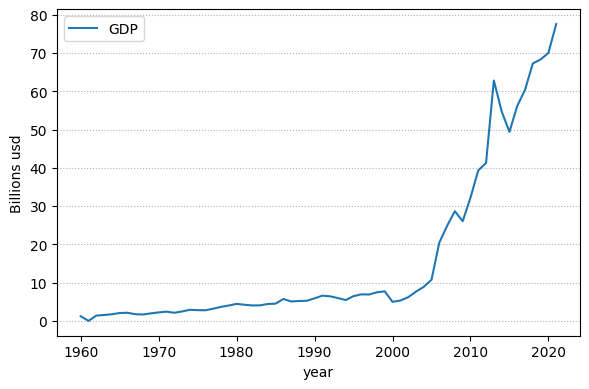

In [12]:
fig_id = 1
plt.figure(figsize=(6,4))
fig = sns.lineplot(data)
scale_factor_y = 1e9
ticks_y = ticker.FuncFormatter(lambda y, pos: '{:.0f}'.format(y/scale_factor_y))
fig.yaxis.set_major_formatter(ticks_y)
fig.yaxis.grid(linestyle=':')

#plt.title("Fig.{} - Annual GDP of Ghana between the years 1960 and 2020".format(fig_id), y=-0.3)
plt.ylabel("Billions usd")
plt.tight_layout()
plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'));

<Figure size 1400x1200 with 0 Axes>

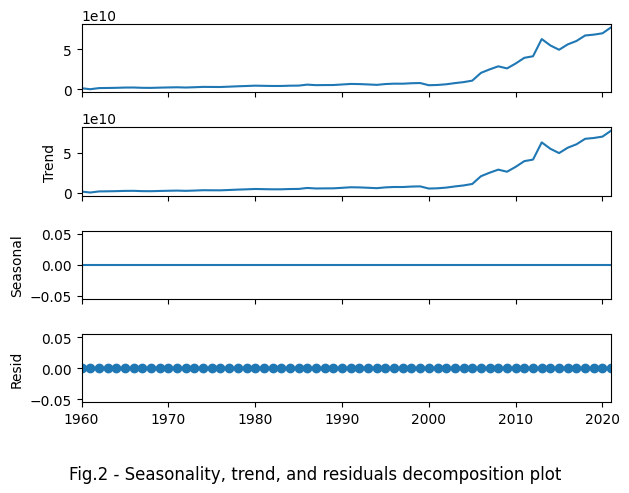

In [11]:
fig_id = 2
result = seasonal_decompose(data)

plt.figure(figsize=(14,12))
result.plot()
plt.suptitle("Fig.{} - Seasonality, trend, and residuals decomposition plot".format(fig_id), y=-0.05)

plt.tight_layout()
plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'));

> Let us increase the scale

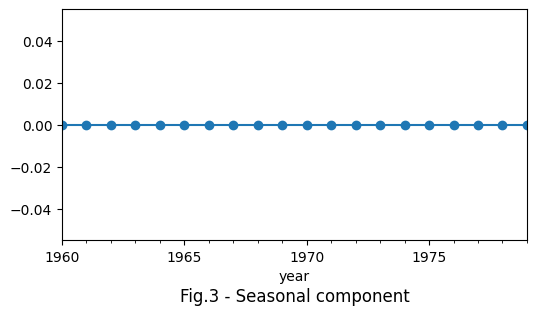

In [7]:
fig_id = 3
plt.figure(figsize=(6,3))
result.seasonal[:20].plot(marker="o")
plt.title('Fig.{} - Seasonal component'.format(fig_id), y=-0.3)
plt.show()

> We may observe a growing trend which has considerably increased since 2005. Our dataset does not change from season to season.

2. Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.
Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

    Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

In [15]:
# Split the data into two samples: train and test
train, test = data.iloc[:-3], data.iloc[-3:]
train.shape, test.shape

((59, 1), (3, 1))

In [47]:
scaler = StandardScaler()

train_scaled = pd.Series(np.squeeze(scaler.fit_transform(train)), name='train_scaled', index=train.index)
test_scaled = pd.Series(np.squeeze(scaler.transform(test)), name='test_scaled', index=test.index)
train_scaled.head(3)

year
1960-01-01   -0.657968
1961-01-01   -0.726214
1962-01-01   -0.648701
Name: train_scaled, dtype: float64

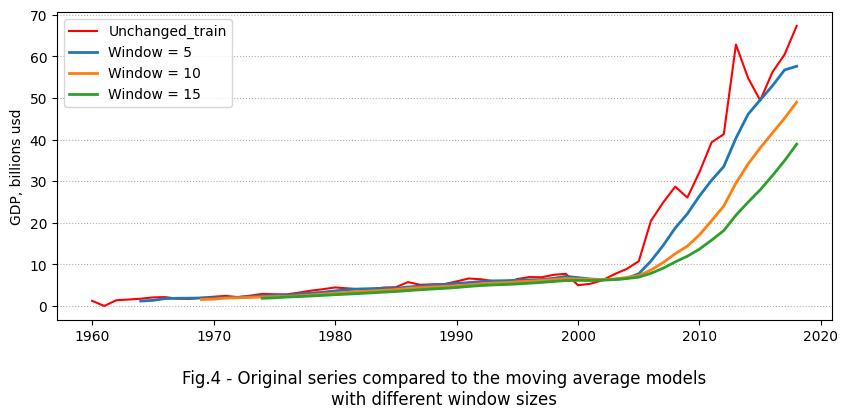

In [ ]:
fig_id = 4
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(train, color="red", label="Unchanged_train")
scale_factor_y = 1e9
ticks_y = ticker.FuncFormatter(lambda y, pos: '{:.0f}'.format(y/scale_factor_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.yaxis.grid(linestyle=':')

window = np.linspace(5,15,3).astype("int8") # Set 3 window sizes: 5,10,15

for i in range(window.shape[0]):
    ax.plot(
        train.rolling(window=window[i]).mean(),
        label="Window = {}".format(window[i]),
        linewidth=2
    )
plt.ylabel("GDP, billions usd")
plt.legend()
plt.title("Fig.{} - Original series compared to the moving average models\nwith different window sizes".format(fig_id), y=-0.3);

> All our models in general repeated the pattern shown by the original dataset. The most precize  model has window size of 5.

3. С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.

    Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

    Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).

In [48]:
train_diff, diff_order = Dickey_Fuller_test(train_scaled)

Attempt 1: non-stationary series
Attempt 2: non-stationary series
Attempt 3: non-stationary series
ADF Statistic: -4.78
p-value: 5.9e-05
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600
Stationary series
Diff order = 3


> The series are converted to stationary mode after it was differentiated 3 times.

In [17]:
train_diff.shape

(56, 1)

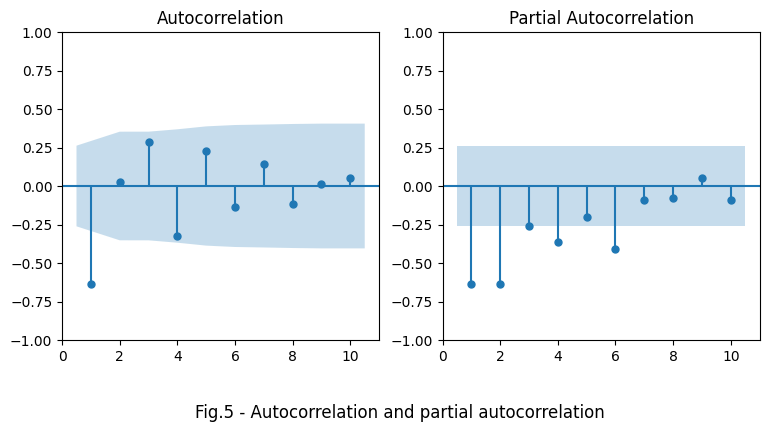

In [18]:
plot_acf_pacf(train_diff, lags=10, fig_id=5)

### ARIMA

In [49]:
p = 2 # last significant lag taken from the partial autocorrelation graph
d = diff_order # difference order
q = 1 # last significant lag taken from the  autocorrelation graph
arima_model = ARIMA(train_diff, order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           train_scaled   No. Observations:                   56
Model:                 ARIMA(2, 3, 1)   Log Likelihood                 -61.905
Date:                Sun, 17 Mar 2024   AIC                            131.809
Time:                        20:38:48   BIC                            139.691
Sample:                    01-01-1963   HQIC                           134.840
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3644      0.041    -33.056      0.000      -1.445      -1.284
ar.L2         -0.8101      0.035    -23.433      0.000      -0.878      -0.742
ma.L1         -0.9991      7.648     -0.131      0.896     -15.989      13.991
sigma2         0.5087      3.872      0.131      0.895      -7.079       8.097
===================================================================================
Ljung-Box (L1) (Q):                   4.56   Jarque-Bera (JB):                51.56
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):             191.08   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Optimization

In [14]:
result = optim_param(data=train_diff, field=np.arange(1,4))
result.head()

C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_mo

,p,d,q,aic
8,1,3,3,2697.25
7,1,3,2,2689.33
6,1,3,1,2683.05
5,1,2,3,2680.01
4,1,2,2,2675.97


In [15]:
# !pip install pmdarima
import pmdarima as pm

smodel = pm.auto_arima(
    train, # unchanged dataset!!!
    start_p=1, max_p=3, start_P=0,
    d=3, D=1,
    start_q=1, max_q=3,
    m=1,
    test="adf",
    error_action="ignore",
    trace=True,seasonal=False
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.04 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.03 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.04 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.06 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.03 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.04 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.738 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Tue, 19 Dec 2023   AIC                           2659.231
Time:                        12:39:47   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+56. Standard errors may be unstable.
"""

4. Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

In [72]:
# substitute optimal parameters  
arima_model = ARIMA(train_scaled, order=(2, 3, 1))
arima_model = arima_model.fit()
arima_pred = arima_model.predict(start=test.index[0], end=test.index[-1])
arima_pred = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(arima_pred)), columns=(['y_hat']), index=test.index) #
arima_pred

,y_hat
year,
2019-01-01,7.361431e+10
2020-01-01,7.941804e+10
2021-01-01,8.608215e+10


5. Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.
6. Сделайте выводы по полученным результатам.

In [73]:
# forecast = arima_model.conf_int(alpha=0.05)
forecast_df = arima_model.get_forecast(len(test.index))
forecast_df = forecast_df.conf_int(alpha=0.05) # Confidence level of 95%
forecast_df = pd.DataFrame(scaler.inverse_transform(forecast_df), columns=(['lower','upper']))
forecast_df

,lower,upper
0,6.529470e+10,8.193392e+10
1,6.581696e+10,9.301912e+10
2,6.660220e+10,1.055621e+11


In [81]:
arima_pred.values

array([[7.36143101e+10],
       [7.94180366e+10],
       [8.60821541e+10]])

In [82]:
prediction_arima = pd.DataFrame({
    'y': test.values.ravel(),
    'y_hat': arima_pred.values.ravel(),
    'ci_lower': forecast_df.iloc[:,0],
    'ci_upper': forecast_df.iloc[:,1]}) # test.reset_index()['year']
#prediction_arima = prediction_arima.set_index(idx)

#prediction_arima.reset_index()
prediction_arima['year'] = np.arange(2019,2022).astype('int16')
prediction_arima = prediction_arima.set_index('year')
prediction_arima

,y,y_hat,ci_lower,ci_upper
year,,,,
2019,6.833754e+10,7.361431e+10,6.529470e+10,8.193392e+10
2020,7.004320e+10,7.941804e+10,6.581696e+10,9.301912e+10
2021,7.759428e+10,8.608215e+10,6.660220e+10,1.055621e+11


In [85]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(prediction_arima['y'],prediction_arima['y_hat']))

7911508768.401322

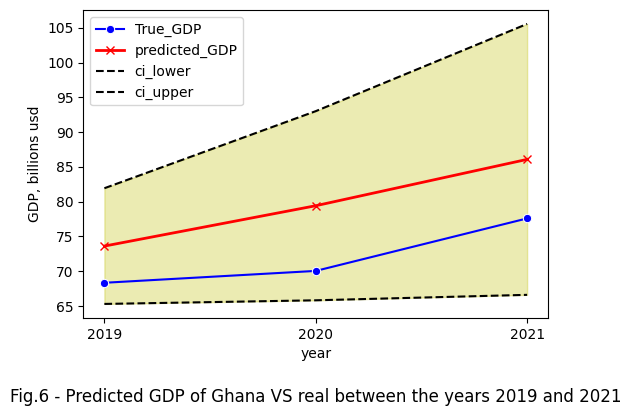

In [88]:
fig_id = 6
x = np.arange(2019,2022).astype('int16') #list(pd.to_datetime(prediction_arima.index).year.values)

plt.figure(figsize=(6,4))
fig = sns.lineplot(prediction_arima['y'], c='b', label='True_GDP', marker='o') #  lw=1
plt.plot(prediction_arima['y_hat'], 'x-r', label='predicted_GDP', lw=2)
plt.plot(prediction_arima[['ci_lower','ci_upper']],'--k',label=['ci_lower','ci_upper'])
plt.fill_between(prediction_arima.index, prediction_arima['ci_lower'].values, prediction_arima['ci_upper'].values, color='y', alpha=0.3)

plt.xticks(np.arange(2019,2022))

scale_factor_y = 1e9
ticks_y = ticker.FuncFormatter(lambda y, pos: '{:.0f}'.format(y/scale_factor_y))
fig.yaxis.set_major_formatter(ticks_y)
plt.ylabel("GDP, billions usd")

plt.legend()
plt.title("Fig.{} - Predicted GDP of Ghana VS real between the years 2019 and 2021".format(fig_id), y=-0.3)
plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'));
 

In [20]:
#prediction_arima.plot()

> Figure 6 illustrates predicted GDP of Ghana compared to real values between the years 2019 and 2021. As we may see, our model spot the growing trend, which stays within the confidence interval of 95%.

# Part 2. Interpolation

2.1 Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода DataFrame.asfreq(), передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц.  

In [21]:
data.head()

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [22]:
data.asfreq(freq='AS') 

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
...,...
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


2.2 Проверьте данные на наличие пропущенных значений (Series.isna().sum()).

In [23]:
data.isna().sum()

GDP    0
dtype: int64

> The dataset does not contain any missing values

2.3 Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN.

In [24]:
# replace null data with nan-values
data['GDP'] = data['GDP'].apply(lambda x: np.nan if x==0 else x)
data.isna().sum()

GDP    1
dtype: int64

> The dataset contain 1 null values

2.4 Для заполнения пропусков выполните интерполяцию с использованием метода .interpolate().

In [25]:
# u=interpolation of to replace missing entries
data['GDP'] = data['GDP'].interpolate(method='linear')
assert data['GDP'].isna().sum() == 0

> We interpolated null values using the linear model.

2.5 Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.

In [26]:
# Split the data into two samples: train and test
train, test = data.iloc[:-3], data.iloc[-3:]
train.shape, test.shape

((59, 1), (3, 1))

In [27]:
# Dickey-Fuller test to estimate the order of stationarity
train_diff, diff_order = Dickey_Fuller_test(train)

Attempt 1: non-stationary series
Attempt 2: non-stationary series
Attempt 3: non-stationary series
ADF Statistic: -4.83
p-value: 4.9e-05
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600
Stationary series
Diff order = 3


In [28]:
train_diff.shape

(56, 1)

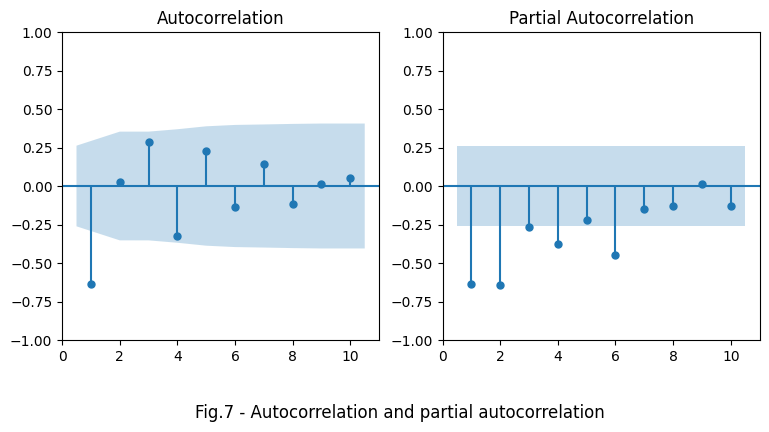

In [29]:
plot_acf_pacf(train_diff, lags=10, fig_id=7)

> Lags on the plot did not change significantly compared to the previous set of graphs

## ARIMA 2

In [30]:
p = 2 # last significant lag taken from the partial autocorrelation graph
d = diff_order # difference order
q = 1 # last significant lag taken from the  autocorrelation graph
arima_model = ARIMA(train_diff, order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   56
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1312.592
Date:                Tue, 19 Dec 2023   AIC                           2633.185
Time:                        12:39:48   BIC                           2641.066
Sample:                    01-01-1963   HQIC                          2636.215
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3949      0.057    -24.646      0.000      -1.506      -1.284
ar.L2         -0.8452      0.047    -17.994      0.000      -0.937      -0.753
ma.L1         -0.9725      0.193     -5.037      0.000      -1.351      -0.594
sigma2      2.681e+20    3.7e-22   7.24e+41      0.000    2.68e+20    2.68e+20
===================================================================================
Ljung-Box (L1) (Q):                   3.82   Jarque-Bera (JB):                57.13
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):             462.70   Skew:                            -0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.19e+57. Standard errors may be unstable.
"""

2.6 Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

> As expected, the ARIMA model showed almost equal AIC score compared to that of the prevoius ARIMA model. So we do not observe significant changes after interpolation of missing data points.

## 3. Volatility

3.1 Посчитайте волатильность для вашего временного ряда: $Vol(t) = |\frac{X_t - X_{t-1}}{X_{t-1}} * 100|$ , %

In [31]:
data['volatility'] = data['GDP'].pct_change().mul(100).abs()
#data['volatility'] = 100 * data['GDP'].pct_change().abs() # equal

data.head(3)

,GDP,volatility
year,,
1960-01-01,1.217087e+09,NaN
1961-01-01,1.299720e+09,6.789413
1962-01-01,1.382353e+09,6.357759


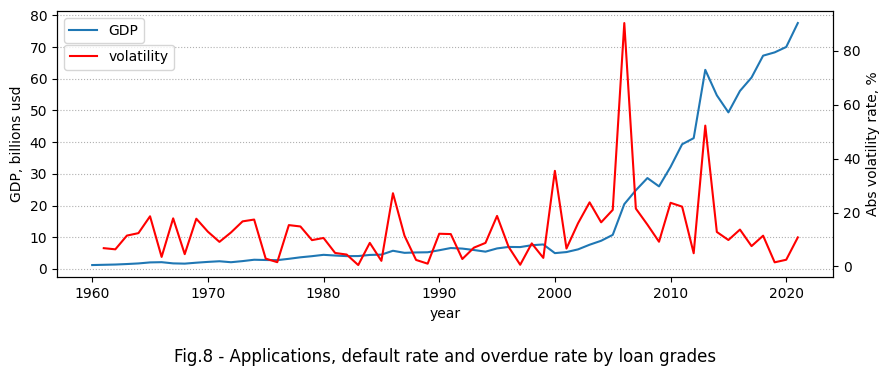

In [32]:
fig_id = 8
fig, ax = plt.subplots(1,1, figsize=(9, 4))
ax = sns.lineplot(data['GDP'], markers='o', label='GDP')
scale_factor_y = 1e9
ticks_y = ticker.FuncFormatter(lambda y, pos: '{:.0f}'.format(y/scale_factor_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.yaxis.grid(linestyle=':')
ax.set_ylabel('GDP, billions usd')

ax2 = ax.twinx() 
ax2 = sns.lineplot(data['volatility'], markers='^', c='r', label='volatility')
ax2.set_ylabel('Abs volatility rate, %')

ax.set_title(f'Fig.{fig_id} - Applications, default rate and overdue rate by loan grades', y=-0.35)
#lns = ax1 + ax2
#labs = [l.get_label() for l in lns]
#ax.legend(lns, labs, loc=0)
ax.legend(loc=0)
ax2.legend(bbox_to_anchor=(0.16, 0.9));
plt.tight_layout();
#plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'));


> Figure 8 shows that the dispersion of annual Ghana's GDP in some years exceeds say, 10%. Let us predict the volatility (dispersion) value.

3.2 Используйте GARCH-модель для предсказания волатильности.

 data: (62, 2)
train: (59,)
 test: (3,)


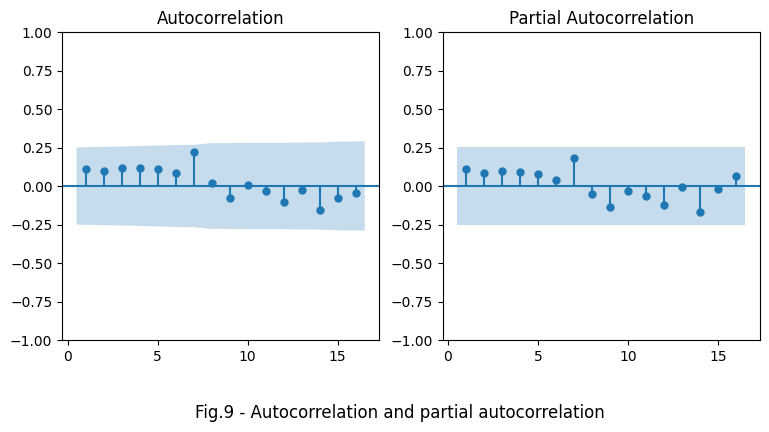

In [33]:
# Split the data into two samples: train and test. Select the volatility feature only
train, test = data.iloc[:-3,1], data.iloc[-3:,1]
print(' data: {}\ntrain: {}\n test: {}'.format(data.shape, train.shape, test.shape))

plot_acf_pacf(data['volatility'].iloc[1:], lags=16, fig_id=9)

In [34]:
display(data.head(2))

#  the Dickey-Fuller test starts from the 1st element since the first value is NaN
train, diff_order = Dickey_Fuller_test(data['volatility'].dropna()) #.iloc[1:]

,GDP,volatility
year,,
1960-01-01,1.217087e+09,NaN
1961-01-01,1.299720e+09,6.789413


ADF Statistic: -6.81
p-value: 2.2e-09
Critical Values:
	1%: -3.544
	5%: -2.911
	10%: -2.593
Stationary series
Diff order = 0


> This dataset is stationary. There are no significant autocorrelation over time with values, except first lag (the previous value).  Let us predict the volatility using GARCH model with folowing parameters: p=1, q=1.

In [35]:
#garch_df = pd.DataFrame(data["volatility"].iloc[1:] )
#garch_df.head()

p = 1
q = 1

#https://arch.readthedocs.io/en/latest/univariate/generated/generated/arch.univariate.base.ARCHModel.fit.html
model = arch_model(data['volatility'].dropna(), vol='GARCH', p=p, q=q)
 
results = model.fit(
    last_obs=test.index[0], #Last observation to use when estimating model
    update_freq=5, #Frequency of iteration updates. If 0, it dissables the iterative output.
    disp="off" # suppresses estimation output
    )
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Tue, Dec 19 2023   Df Residuals:                       57
Time:                        12:39:49   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.790  1.666e-06 [  7.279, 17.360]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6700     24.738      0.148      0.882 [-44.817, 52.157]
alpha[1]   6.0947e-11  9.201e-02  6.624e-10      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.725e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

In [36]:
predictions_df = pd.DataFrame(test) #test.copy()
predictions_df['arch_predictions'] = results.forecast(reindex=False).residual_variance.loc[test.index]
#garch_pred.rename(columns={'h.1': 'variance_forecast'},inplace=True)
predictions_df

,volatility,arch_predictions
year,,
2019-01-01,1.542746,288.546011
2020-01-01,2.495937,292.216032
2021-01-01,10.780603,295.886053


In [37]:
print("Root Mean Squared Error: {:.1f}".format(np.sqrt(mean_squared_error(
    predictions_df["volatility"].abs(), predictions_df["arch_predictions"]).round(2))))

Root Mean Squared Error: 287.3


> The forcasted volatility is very imprecise.

3.3 Используйте линейную регрессию для получения прогноза.

3.4 Визуализируйте полученное предсказание вместе с фактическим значением.



#### linear model

In [38]:
X_train, X_test = np.arange(train.shape[0]).reshape(-1, 1), np.arange(test.shape[0]).reshape(-1, 1) #.fillna(0)
y_train, y_test = train.values, test.values

In [39]:
# Instance
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)
predictions_df['linear_predictions'] = lr.predict(X_test)

print("Root Mean Squared Error: {:.1f}".format(np.sqrt(mean_squared_error(
    predictions_df["volatility"].abs(), predictions_df["linear_predictions"]).round(2))))

display(predictions_df)

Root Mean Squared Error: 5.6


,volatility,arch_predictions,linear_predictions
year,,,
2019-01-01,1.542746,288.546011,8.641577
2020-01-01,2.495937,292.216032,8.788200
2021-01-01,10.780603,295.886053,8.934823


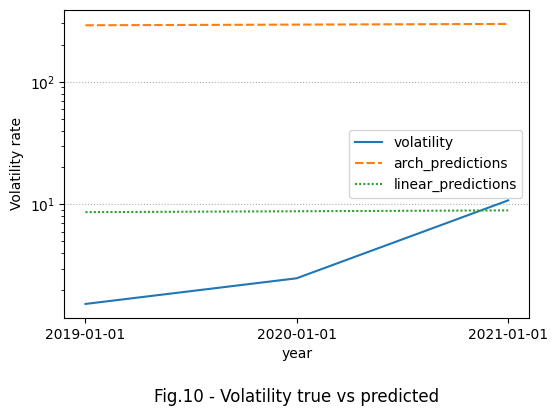

In [40]:
fig_id = 10
plt.figure(figsize=(6,4))
fig = sns.lineplot(predictions_df)

plt.xticks(test.index)
fig.yaxis.grid(linestyle=':')
plt.yscale('log')

plt.title("Fig.{} - Volatility true vs predicted".format(fig_id), y=-0.3)
plt.ylabel("Volatility rate")
plt.show();

3.5 Сравните результаты и сделайте выводы.

> Although the linear model predicts volatility up to the scale, it does not reflect any change in volatility in contrast to the arch model. The latter model, however, is very imprecise. Its large mean squared error metric was likely caused by limitation of test dataset.

# Prophet

In [90]:
train_df = train.reset_index()
train_df.rename(columns={'year':'ds','volatility':'y'}, inplace=True)
train_df

,ds,GDP
0,1960-01-01,1.217087e+09
1,1961-01-01,0.000000e+00
2,1962-01-01,1.382353e+09
3,1963-01-01,1.540616e+09
...,...,...
55,2015-01-01,4.940657e+10
56,2016-01-01,5.616517e+10
57,2017-01-01,6.040638e+10
58,2018-01-01,6.729928e+10


In [95]:
prophet_model = Prophet()
#prophet_model.fit(train_df.iloc[:-3])
prophet_model.fit(train_scaled.reset_index().rename(columns={'year':'ds','train_scaled':'y'}))

23:43:44 - cmdstanpy - INFO - Chain [1] start processing
23:43:44 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
test_df = test_scaled.copy().reset_index()
test_df.rename(columns={'year':'ds','train_scaled':'y'}, inplace=True)
test_df

,ds,y
0,2019-01-01,1.542746
1,2020-01-01,2.495937
2,2021-01-01,10.780603


In [44]:
future_df = prophet_model.make_future_dataframe(periods=4, freq='y')
future_df

,ds
0,1961-01-01
1,1962-01-01
2,1963-01-01
3,1964-01-01
...,...
58,2018-12-31
59,2019-12-31
60,2020-12-31
61,2021-12-31


In [45]:
forecast_df = prophet_model.predict(test_df)
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
0,2019-01-01,19.605466,2.645566,36.220934
1,2020-01-01,17.944480,0.535138,34.739957
2,2021-01-01,21.578004,3.891968,37.150608


<Figure size 600x400 with 0 Axes>

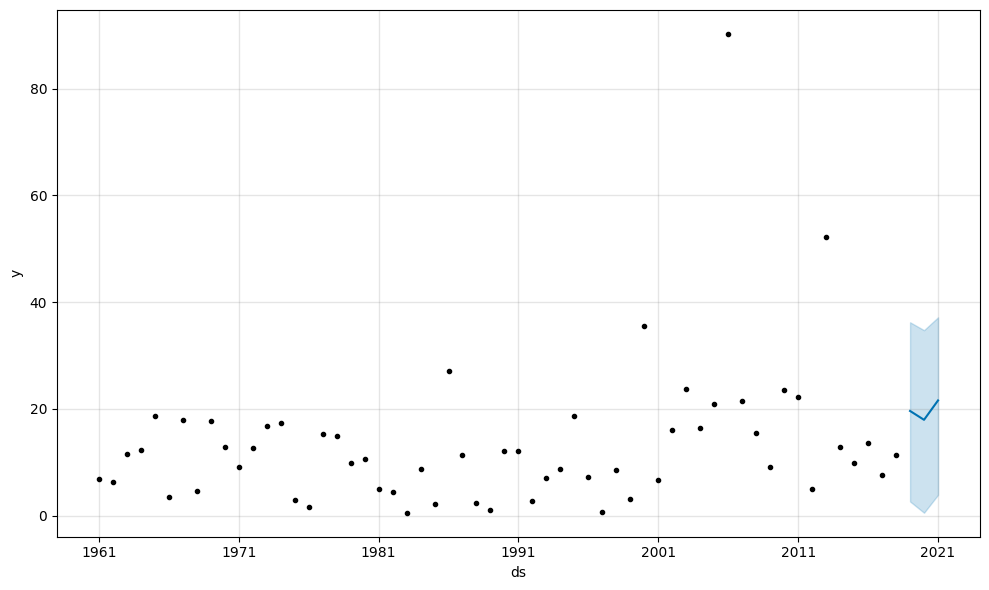

In [46]:
plt.figure(figsize=(6,4))
prophet_model.plot(forecast_df);

In [47]:
predictions_df['prophet_predictions'] = forecast_df['yhat'].values

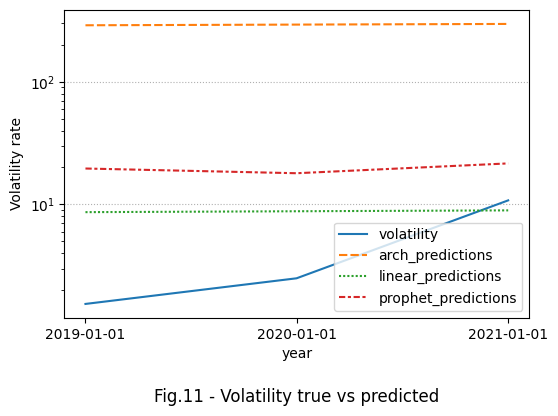

In [48]:
fig_id = 11
plt.figure(figsize=(6,4))
fig = sns.lineplot(predictions_df)

plt.xticks(test.index)
fig.yaxis.grid(linestyle=':')
plt.yscale('log')

plt.title("Fig.{} - Volatility true vs predicted".format(fig_id), y=-0.3)
plt.ylabel("Volatility rate")
plt.show();

> Prophet model has identified some changes of GDP volatility, but its results are not crediable due to small number of data entries.